In [16]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.

It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os, glob
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils

In [26]:
batch_size = 8
num_classes = 2
epochs = 100
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# cifar10

In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# original dataset

In [32]:
# フォルダの中にある画像を順次読み込む
# カテゴリーは0から始める

X = []
Y = []

path = 'C:/Users/shihnkawa/Pictures/ダウンロード/'

# 対象Aの画像
for picture in glob.glob(path+'whale/*.???'):
    img = img_to_array(load_img(picture, target_size=(32,32)))
    X.append(img)

    Y.append(0)


# 対象Bの画像
for picture in glob.glob(path+'apple/*.???'):
    img = img_to_array(load_img(picture, target_size=(32,32)))
    X.append(img)

    Y.append(1)


# arrayに変換
X = np.asarray(X)
Y = np.asarray(Y)

# 画素値を0から1の範囲に変換
X = X.astype('float32')
X = X / 255.0

# クラスの形式を変換
Y = np_utils.to_categorical(Y, 2)

# 学習用データとテストデータ
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=111)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (65, 32, 32, 3)
65 train samples
33 test samples


In [30]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 15, 15, 64)        18496     
__________

In [33]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_test, Y_test),
                        epochs=nb_epoch, verbose=1, max_q_size=100,
                        shuffle=True,
                        callbacks=[lr_reducer, early_stopper, csv_logger])
    
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/100
8/8 [==============================] - 5s 570ms/step - loss: 1.8268 - acc: 0.2969 - val_loss: 0.9263 - val_acc: 0.5152
Epoch 2/100
8/8 [==============================] - 3s 375ms/step - loss: 1.0669 - acc: 0.2376 - val_loss: 0.8107 - val_acc: 0.3333
Epoch 3/100
8/8 [==============================] - 3s 426ms/step - loss: 0.8217 - acc: 0.3643 - val_loss: 0.6926 - val_acc: 0.5758
Epoch 4/100
8/8 [==============================] - 3s 377ms/step - loss: 0.6905 - acc: 0.4593 - val_loss: 0.6550 - val_acc: 0.7273
Epoch 5/100
8/8 [==============================] - 3s 381ms/step - loss: 0.6994 - acc: 0.6199 - val_loss: 0.5678 - val_acc: 0.8788
Epoch 6/100
8/8 [==============================] - 3s 418ms/step - loss: 0.6181 - acc: 0.7286 - val_loss: 0.5296 - val_acc: 0.9394
Epoch 7/100
8/8 [==============================] - 4s 494ms/step - loss: 0.5116 - acc: 0.8258 - val_loss: 0.5076 - val_acc: 0.7879
Epoch 8/100
8/8 [==============================]

KeyboardInterrupt: 

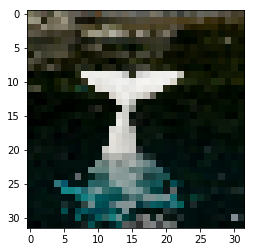

(<matplotlib.image.AxesImage at 0x238afa20198>, None)

In [39]:
import matplotlib.pyplot as  plt
%matplotlib inline

plt.imshow(x_test[2]),plt.show()

In [37]:
y_test[1]

array([0., 1.], dtype=float32)

In [38]:
y_test[2]

array([1., 0.], dtype=float32)